# Stock Price Prediction w/ XGBoost Time Series Forecasting

### Objective

####  Build and train a model to predict the daily adjusted closing prices of Tesla (TSLA), using data from previous days. This experiment will consist of data starting from TSLA's IPO date which is 2013-06-29 to 2023-05-24

## Standard imports

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastai.tabular.all import add_datepart
import seaborn as sns
import xgboost as xgb

## Loading Data

In [3]:
# Getting TSLA data from yfinance
tsla = yf.download('tsla', end="2023-05-25")

[*********************100%***********************]  1 of 1 completed


In [4]:
tsla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2023-05-18,174.220001,177.059998,172.449997,176.889999,176.889999,109520300
2023-05-19,177.169998,181.949997,176.309998,180.139999,180.139999,136024200
2023-05-22,180.699997,189.320007,180.110001,188.869995,188.869995,132001400


## Cleaning Data

In [5]:
tsla.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [6]:
tsla.reset_index(inplace=True)

In [7]:
tsla

,Date,Adj Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3244,2023-05-18,176.889999
3245,2023-05-19,180.139999
3246,2023-05-22,188.869995
3247,2023-05-23,185.770004


<Axes: xlabel='Date'>

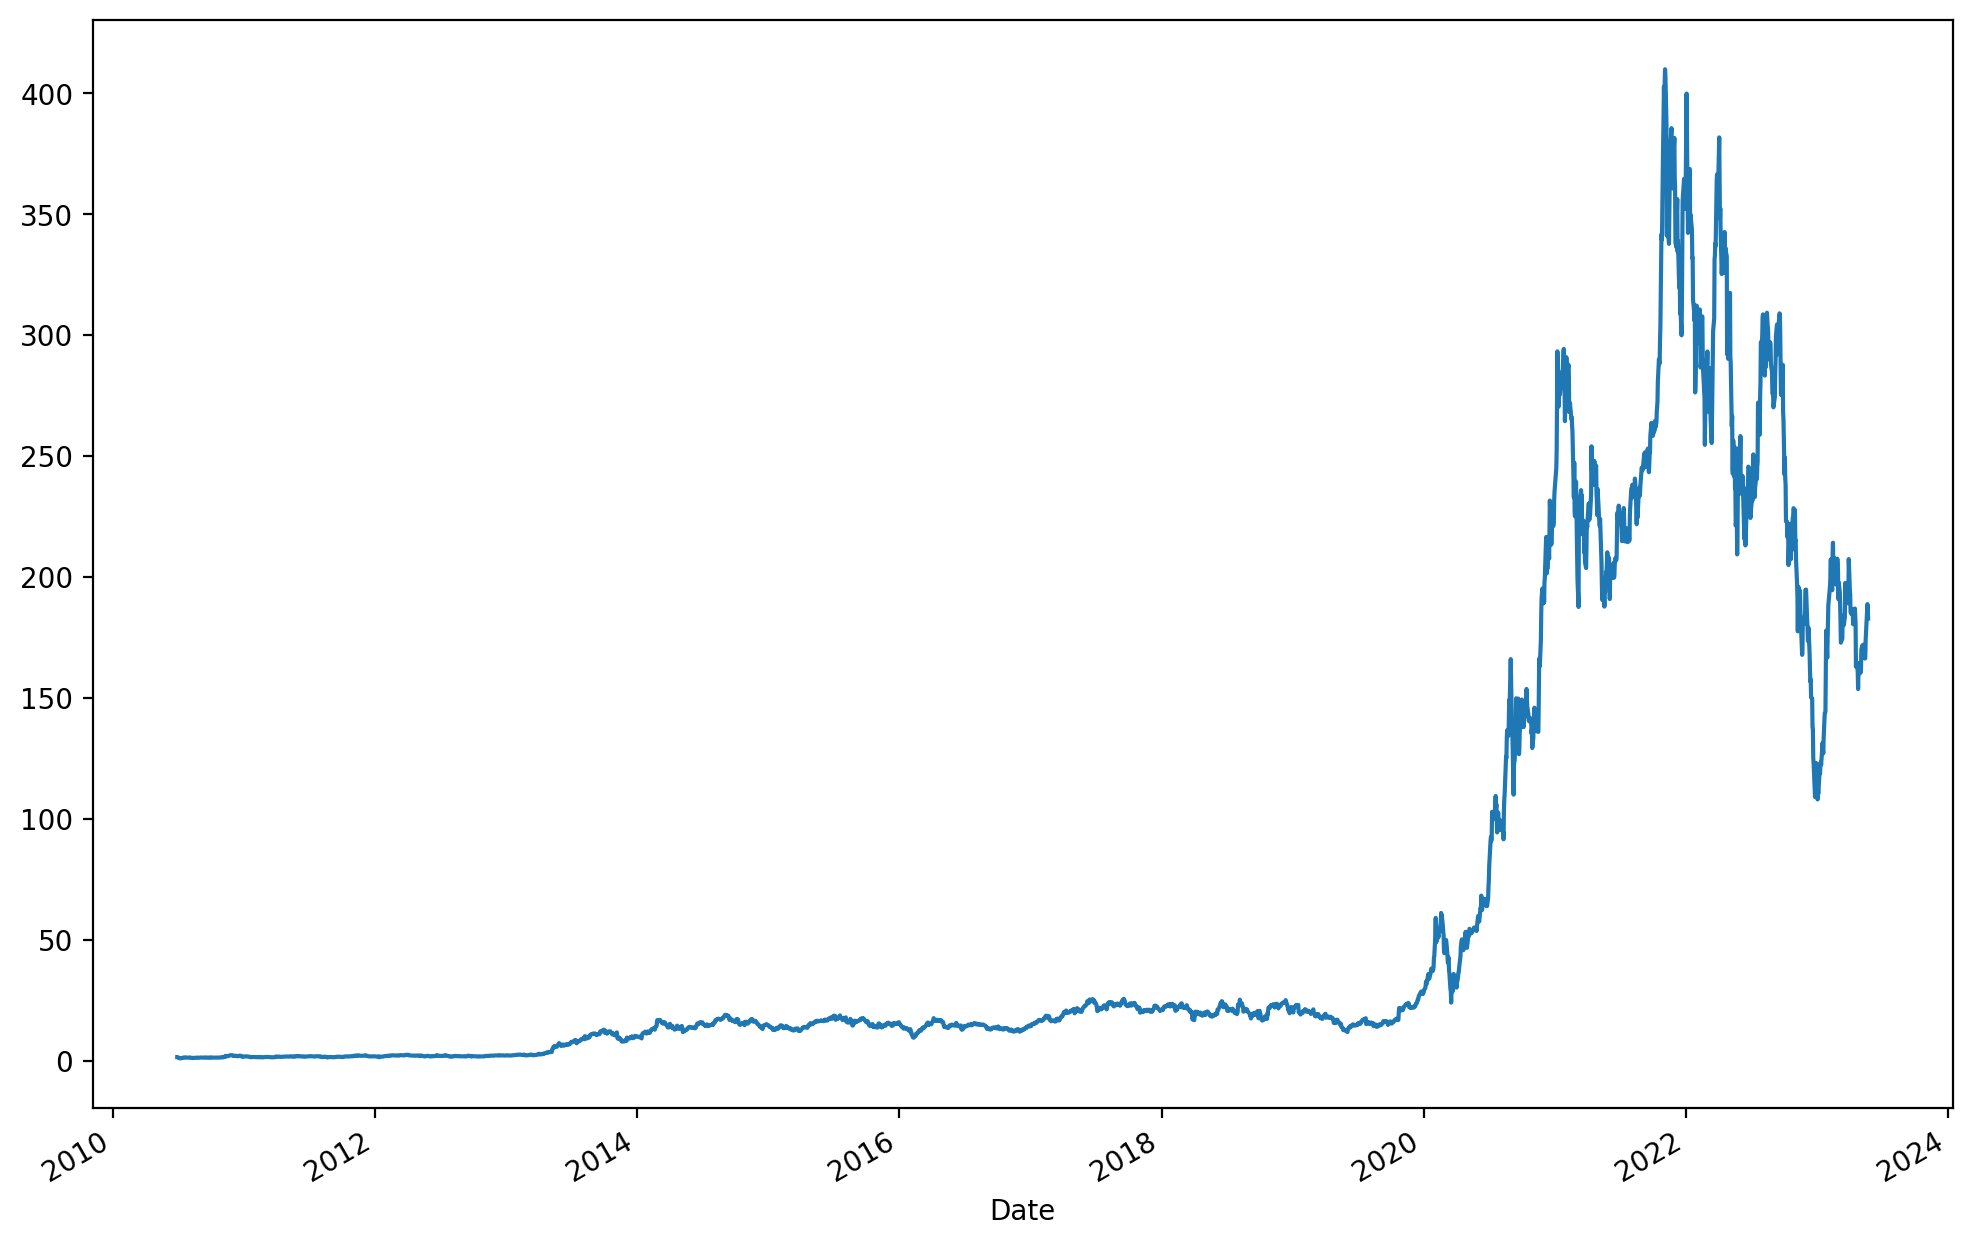

In [8]:
plt.figure(dpi=200, figsize=(12, 8))
tsla.set_index('Date')['Adj Close'].plot()

## Feature Engineering: Adjusting dates

In [9]:
# Creating new date features
add_datepart(tsla, 'Date', drop=False)
tsla.drop('Elapsed', axis=1, inplace=True)

In [10]:
tsla

,Date,Adj Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2010-06-29,1.592667,2010,6,26,29,1,180,False,False,False,False,False,False
1,2010-06-30,1.588667,2010,6,26,30,2,181,True,False,True,False,False,False
2,2010-07-01,1.464000,2010,7,26,1,3,182,False,True,False,True,False,False
3,2010-07-02,1.280000,2010,7,26,2,4,183,False,False,False,False,False,False
4,2010-07-06,1.074000,2010,7,27,6,1,187,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,2023-05-18,176.889999,2023,5,20,18,3,138,False,False,False,False,False,False
3245,2023-05-19,180.139999,2023,5,20,19,4,139,False,False,False,False,False,False
3246,2023-05-22,188.869995,2023,5,21,22,0,142,False,False,False,False,False,False
3247,2023-05-23,185.770004,2023,5,21,23,1,143,False,False,False,False,False,False


## Exploratory Data Analysis (EDA)

In [11]:
tsla.isnull().sum()

Date                0
Adj Close           0
Year                0
Month               0
Week                0
Day                 0
Dayofweek           0
Dayofyear           0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
dtype: int64

In [12]:
# Compute average price for each month
tsla_month = tsla.groupby('Month').agg({'Adj Close' : 'mean'}).reset_index()

In [13]:
tsla_month

,Month,Adj Close
0,1,66.640007
1,2,69.984840
2,3,68.165317
3,4,68.012559
4,5,58.612863
5,6,52.081150
6,7,52.261582
7,8,59.603068
8,9,62.921993
9,10,58.740434


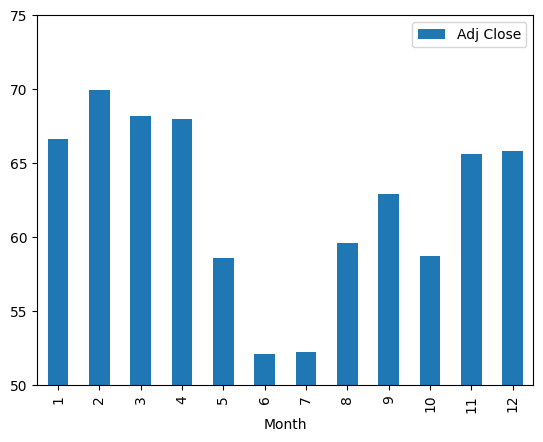

In [14]:
# The plot below shows the average adjusted closing price for each month. We can see that mid year months tend to have a lower value
tsla_month.plot(kind='bar', x='Month', y='Adj Close', ylim=(50, 75));

In [15]:
# Compute average price for each year
tsla_year = tsla.groupby('Year').agg({'Adj Close' : 'mean'}).reset_index()

In [16]:
tsla_year

,Year,Adj Close
0,2010,1.556123
1,2011,1.786984
2,2012,2.077907
3,2013,6.960082
4,2014,14.888606
5,2015,15.336193
6,2016,13.984484
7,2017,20.954420
8,2018,21.153995
9,2019,18.235347


<Axes: xlabel='Year', ylabel='Adj Close'>

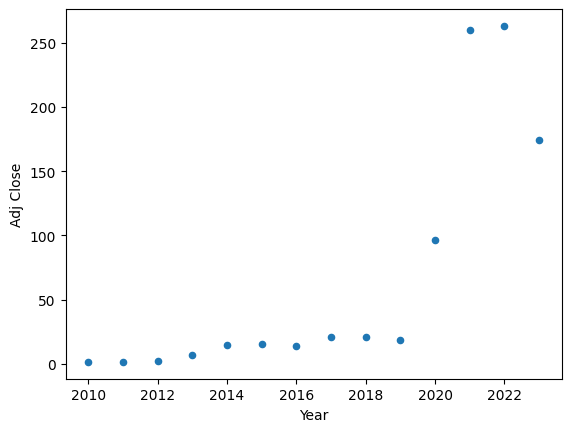

In [17]:
# The plot below shows the average adjusted closing price for each year. We can see the growth in 2020 and slight pullback in 2023.
tsla_year.plot.scatter(x='Year', y='Adj Close')

In [18]:
# Compute average price for each day of the week
DoW = tsla.groupby('Dayofweek').agg({'Adj Close' : 'mean'}).reset_index()

In [19]:
DoW

,Dayofweek,Adj Close
0,0,62.281138
1,1,62.777343
2,2,62.908106
3,3,62.321539
4,4,61.326773


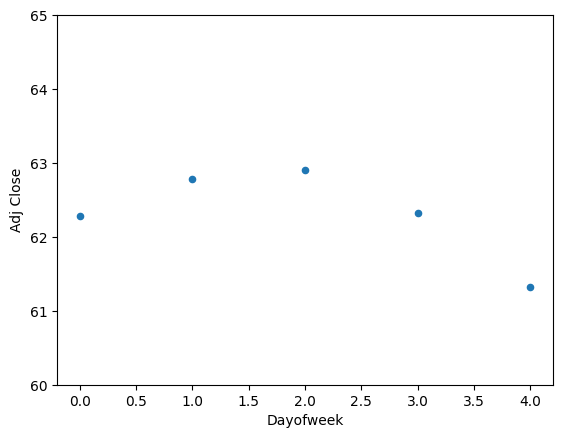

In [20]:
# The plot below shows the average adjusted closing price for each day of the week. 
# We can see that the end of the week seems to be slightly lower than the mid week

DoW.plot(kind='scatter', x='Dayofweek', y='Adj Close', ylim=(60, 65));

#### Adding Lag

In [21]:
def add_lags(df, num_days, col):
    """
    df = takes in data frame 
    num_days = add lags up to the number of days 
    cols = the columns to create lag on
    
    """
    # Create a df for lags
    df_lags = df.copy()
    
    # Copy a column called 'lag_date'
    df_lags['lag_date'] = [x for x in range(len(df))]
    
    merge_keys = ['lag_date']
    lag_days = [x+1 for x in range(num_days)]
    
    for lag in lag_days:
        shift = df_lags[merge_keys + col].copy()
        shift['lag_date'] = shift['lag_date'] + lag
        
        func = lambda x: f'{x}_lag_{lag}' if x in col else x 
        shift = shift.rename(columns=func)
        
        df_lags = pd.merge(df_lags, shift, on=merge_keys, how='left')
    
    del shift
    return df_lags

In [22]:
tsla_lags = add_lags(tsla, 10, ['Adj Close'])

In [23]:
tsla_lags

,Date,Adj Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,...,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,Adj Close_lag_8,Adj Close_lag_9,Adj Close_lag_10
0,2010-06-29,1.592667,2010,6,26,29,1,180,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-06-30,1.588667,2010,6,26,30,2,181,True,False,...,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-01,1.464000,2010,7,26,1,3,182,False,True,...,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-02,1.280000,2010,7,26,2,4,183,False,False,...,1.464000,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-06,1.074000,2010,7,27,6,1,187,False,False,...,1.280000,1.464000,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,2023-05-18,176.889999,2023,5,20,18,3,138,False,False,...,173.860001,166.520004,166.350006,167.979996,172.080002,168.539993,169.149994,171.789993,170.059998,161.199997
3245,2023-05-19,180.139999,2023,5,20,19,4,139,False,False,...,176.889999,173.860001,166.520004,166.350006,167.979996,172.080002,168.539993,169.149994,171.789993,170.059998
3246,2023-05-22,188.869995,2023,5,21,22,0,142,False,False,...,180.139999,176.889999,173.860001,166.520004,166.350006,167.979996,172.080002,168.539993,169.149994,171.789993
3247,2023-05-23,185.770004,2023,5,21,23,1,143,False,False,...,188.869995,180.139999,176.889999,173.860001,166.520004,166.350006,167.979996,172.080002,168.539993,169.149994


In [24]:
temp = ['Adj Close']

In [25]:
temp

['Adj Close']

In [26]:
for n in range(1, 11):
    temp.append(f'Adj Close_lag_{n}')

In [27]:
lag_corr = tsla_lags[temp].corr()

In [28]:
lag_corr

,Adj Close,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,Adj Close_lag_8,Adj Close_lag_9,Adj Close_lag_10
Adj Close,1.000000,0.998911,0.997911,0.996876,0.995840,0.994694,0.993579,0.992483,0.991183,0.990016,0.988647
Adj Close_lag_1,0.998911,1.000000,0.998910,0.997910,0.996874,0.995839,0.994693,0.993580,0.992484,0.991182,0.990013
Adj Close_lag_2,0.997911,0.998910,1.000000,0.998910,0.997910,0.996874,0.995839,0.994696,0.993583,0.992486,0.991181
Adj Close_lag_3,0.996876,0.997910,0.998910,1.000000,0.998911,0.997911,0.996876,0.995845,0.994702,0.993588,0.992487
Adj Close_lag_4,0.995840,0.996874,0.997910,0.998911,1.000000,0.998910,0.997911,0.996878,0.995847,0.994702,0.993586
Adj Close_lag_5,0.994694,0.995839,0.996874,0.997911,0.998910,1.000000,0.998910,0.997912,0.996878,0.995846,0.994701
Adj Close_lag_6,0.993579,0.994693,0.995839,0.996876,0.997911,0.998910,1.000000,0.998911,0.997912,0.996878,0.995844
Adj Close_lag_7,0.992483,0.993580,0.994696,0.995845,0.996878,0.997912,0.998911,1.000000,0.998910,0.997911,0.996877
Adj Close_lag_8,0.991183,0.992484,0.993583,0.994702,0.995847,0.996878,0.997912,0.998910,1.000000,0.998910,0.997911
Adj Close_lag_9,0.990016,0.991182,0.992486,0.993588,0.994702,0.995846,0.996878,0.997911,0.998910,1.000000,0.998910


#### The heatmap below shows the correlation of lags with the Adjusted Close price. As expected, the more recent the price, the more correlated it is.

<Axes: >

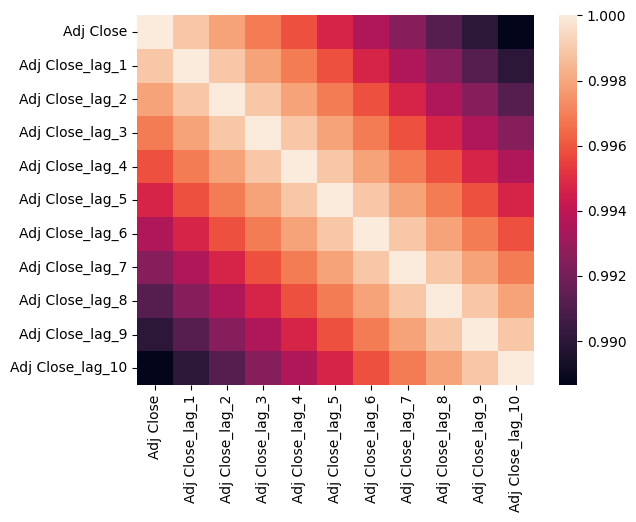

In [29]:
sns.heatmap(lag_corr)

## Train / Test Split

#### Given the large span of data (13 years), I figured the more accurate way to train/test split would be by Time Series Cross Validation. scikit learn conveniently has a model that helps split and test data according to your needs. In this experient, I will split the entire data by 4 for training and the following year for testing.

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [31]:
#

tss = TimeSeriesSplit(n_splits=6, test_size=252, gap=0)

In [32]:
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=252)

In [33]:
tsla.set_index('Date', inplace=True)

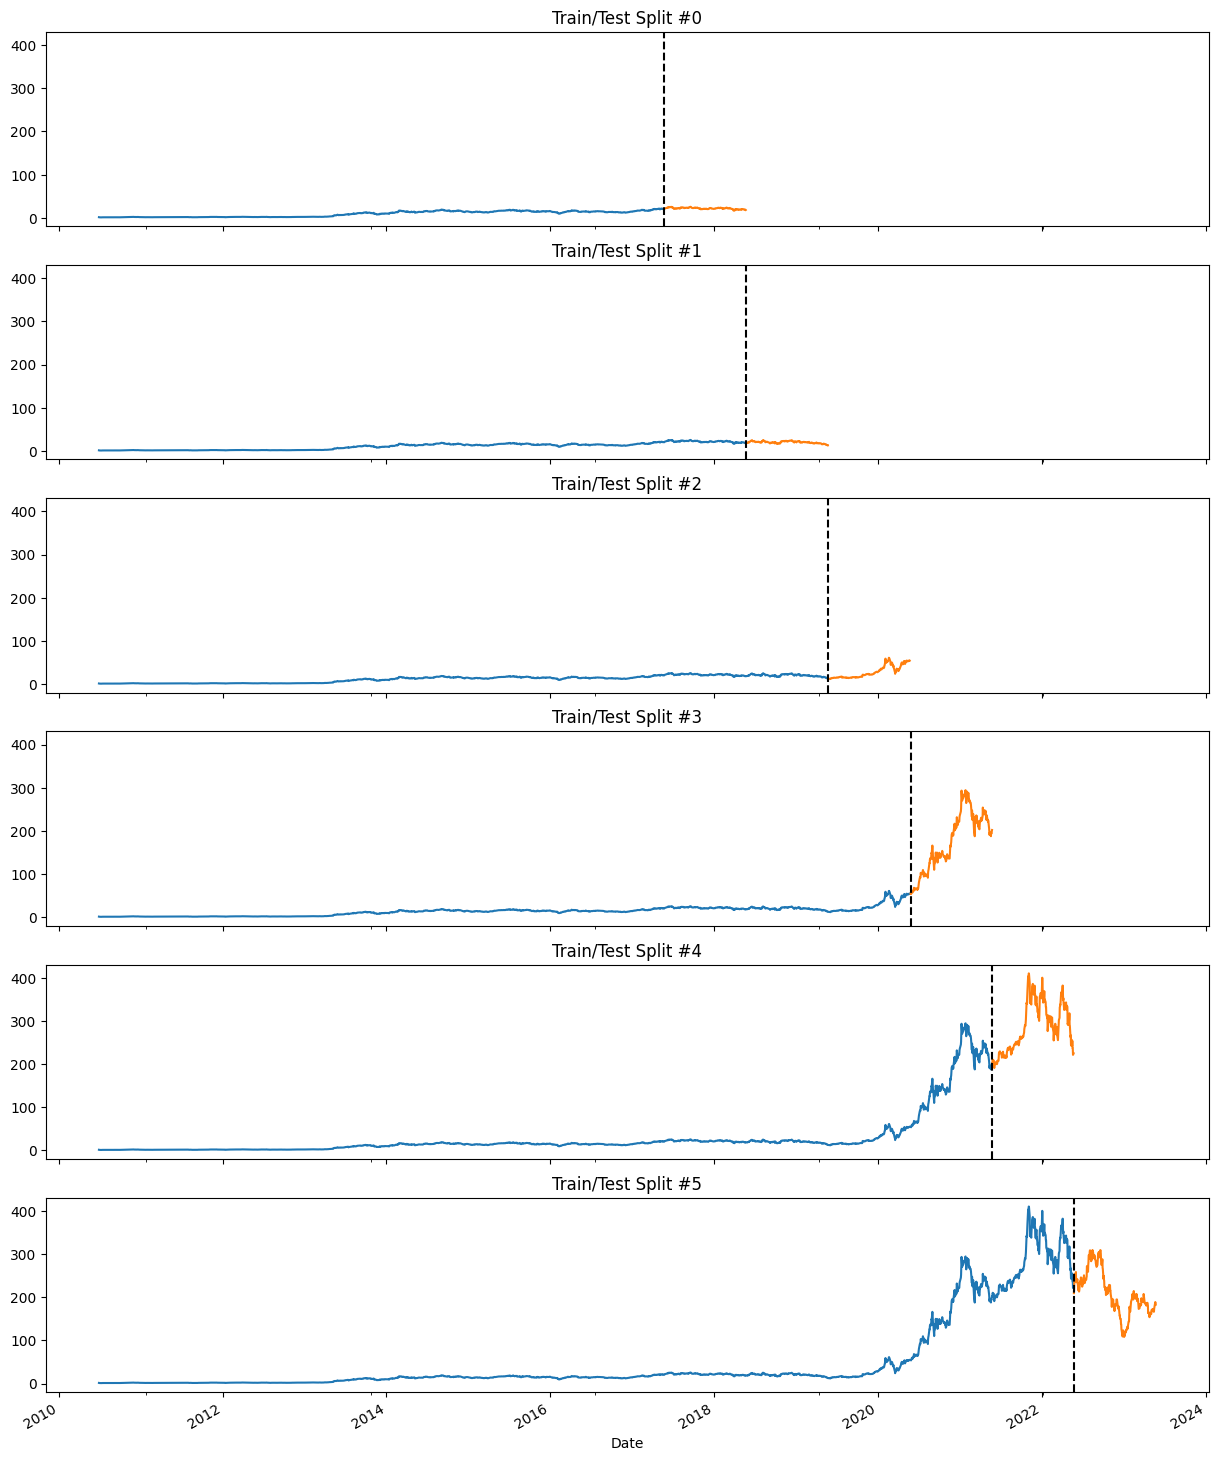

In [34]:
fig, axs = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
iter = 0

for train_idx, test_idx in tss.split(tsla):
    train = tsla.iloc[train_idx]
    test = tsla.iloc[test_idx]
    train['Adj Close'].plot(ax=axs[iter],
                           label='Training Set',
                           title=f'Train/Test Split #{iter}')
    test['Adj Close'].plot(ax=axs[iter],
                          label='Test Set')
    axs[iter].axvline(test.index.min(), color='black', ls='--')

    iter += 1
plt.show()

## Train and Create Model w/ Cross Validation

In [35]:
tsla_lags.set_index('Date', inplace=True)

In [47]:
iter = 0
predictions = []
scores = []

for train_idx, test_idx in tss.split(tsla_lags):
    train = tsla_lags.iloc[train_idx]
    test = tsla_lags.iloc[test_idx]
    
    FEATURES = ['Year', 'Month', 'Week', 'Day', 'Dayofweek' ,'Dayofyear',
                'Adj Close_lag_1', 'Adj Close_lag_2', 'Adj Close_lag_3', 'Adj Close_lag_4', 'Adj Close_lag_5',
               'Adj Close_lag_6', 'Adj Close_lag_7', 'Adj Close_lag_8', 'Adj Close_lag_9', 'Adj Close_lag_10']
    TARGET = 'Adj Close'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Create Model
    model = xgb.XGBRegressor(n_estimators=500,
                           max_depth=3,
                           learning_rate=0.3,
                           objective='reg:squarederror',
                           base_score=0.5,
                           booster='gbtree',
                            seed=100,
                            gamma=0)
    
    # Train Model
    model.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_predict = model.predict(X_test)
    predictions.append(y_predict)
    
    score = np.sqrt(mean_squared_error(y_test, y_predict))
    scores.append(score)

    

[0]	validation_0-rmse:7.56893	validation_1-rmse:16.47435
[100]	validation_0-rmse:0.16984	validation_1-rmse:1.88438
[200]	validation_0-rmse:0.10853	validation_1-rmse:1.88014
[300]	validation_0-rmse:0.07588	validation_1-rmse:1.88025
[400]	validation_0-rmse:0.05410	validation_1-rmse:1.88488
[499]	validation_0-rmse:0.04045	validation_1-rmse:1.89066
[0]	validation_0-rmse:8.90482	validation_1-rmse:14.00805
[100]	validation_0-rmse:0.20340	validation_1-rmse:0.84919
[200]	validation_0-rmse:0.13551	validation_1-rmse:0.86693
[300]	validation_0-rmse:0.09611	validation_1-rmse:0.87368
[400]	validation_0-rmse:0.07178	validation_1-rmse:0.87982
[499]	validation_0-rmse:0.05615	validation_1-rmse:0.88025
[0]	validation_0-rmse:9.60469	validation_1-rmse:25.70605
[100]	validation_0-rmse:0.25090	validation_1-rmse:14.54131
[200]	validation_0-rmse:0.17203	validation_1-rmse:14.53823
[300]	validation_0-rmse:0.12463	validation_1-rmse:14.47451
[400]	validation_0-rmse:0.09456	validation_1-rmse:14.52372
[499]	validat

In [48]:
print(f'RMSE Score {np.mean(scores):0.3f}')
print(f'Fold scores:{scores}')

RMSE Score 37.146
Fold scores:[1.8906560765365423, 0.8802548954738945, 14.535273545888082, 138.15102719619378, 53.336669793443214, 14.080551136541736]


## Predicting the Future

In [194]:
# Retrain all data

FEATURES = ['Year', 'Month', 'Week', 'Day', 'Dayofweek' ,'Dayofyear']
TARGET = 'Adj Close'

In [195]:
X_all = tsla_lags[FEATURES]
y_all = tsla_lags[TARGET]

In [246]:
model = xgb.XGBRegressor(n_estimators=11000,
                           max_depth=3,
                           learning_rate=1.8,
                           objective='reg:squarederror',
                           base_score=0.5,
                           booster='gbtree')

In [247]:
model.fit(X_all, y_all,
         eval_set=[(X_all, y_all)],
         verbose=500)

[0]	validation_0-rmse:91.47644
[500]	validation_0-rmse:1.92840
[1000]	validation_0-rmse:1.21102
[1500]	validation_0-rmse:0.87370
[2000]	validation_0-rmse:0.67872
[2500]	validation_0-rmse:0.53751
[3000]	validation_0-rmse:0.43446
[3500]	validation_0-rmse:0.35732
[4000]	validation_0-rmse:0.29348
[4500]	validation_0-rmse:0.24416
[5000]	validation_0-rmse:0.20787
[5500]	validation_0-rmse:0.17697
[6000]	validation_0-rmse:0.15238
[6500]	validation_0-rmse:0.13160
[7000]	validation_0-rmse:0.11492
[7500]	validation_0-rmse:0.10107
[8000]	validation_0-rmse:0.08768
[8500]	validation_0-rmse:0.07744
[9000]	validation_0-rmse:0.06873
[9500]	validation_0-rmse:0.06173
[10000]	validation_0-rmse:0.05500
[10500]	validation_0-rmse:0.04948
[10999]	validation_0-rmse:0.04481


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1.8, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=11000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Create skeleton date frame using last date

In [70]:
tsla_lags.index.max()

Timestamp('2023-05-24 00:00:00')

In [180]:
future_tsla_dates = pd.date_range('2023-05-25', '2024-05-24')
future_tsla_df = pd.DataFrame(index=future_tsla_dates)

In [181]:
future_tsla_df['isFuture'] = True
tsla_lags['isFuture'] = False

In [182]:
future_tsla_df

,isFuture
2023-05-25,True
2023-05-26,True
2023-05-27,True
2023-05-28,True
2023-05-29,True
...,...
2024-05-20,True
2024-05-21,True
2024-05-22,True
2024-05-23,True


In [183]:
past_and_future = pd.concat([tsla_lags, future_tsla_df])

In [184]:
past_and_future

C:\Users\ossca\miniconda3\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\Users\ossca\miniconda3\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Adj Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,...,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,Adj Close_lag_8,Adj Close_lag_9,Adj Close_lag_10,isFuture
2010-06-29,1.592667,2010.0,6.0,26.0,29.0,1.0,180.0,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2010-06-30,1.588667,2010.0,6.0,26.0,30.0,2.0,181.0,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2010-07-01,1.464000,2010.0,7.0,26.0,1.0,3.0,182.0,False,True,False,...,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2010-07-02,1.280000,2010.0,7.0,26.0,2.0,4.0,183.0,False,False,False,...,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2010-07-06,1.074000,2010.0,7.0,27.0,6.0,1.0,187.0,False,False,False,...,1.464000,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [185]:
past_and_future.reset_index(inplace=True)
past_and_future.rename(columns={'index' : 'Date'}, inplace=True)

In [188]:
past_and_future

,Date,Adj Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,...,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,Adj Close_lag_8,Adj Close_lag_9,Adj Close_lag_10,isFuture
0,2010-06-29,1.592667,2010,6,26,29,1,180,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2010-06-30,1.588667,2010,6,26,30,2,181,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2010-07-01,1.464000,2010,7,26,1,3,182,False,True,...,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2010-07-02,1.280000,2010,7,26,2,4,183,False,False,...,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2010-07-06,1.074000,2010,7,27,6,1,187,False,False,...,1.464000,1.588667,1.592667,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,2024-05-20,NaN,2024,5,21,20,0,141,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3611,2024-05-21,NaN,2024,5,21,21,1,142,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3612,2024-05-22,NaN,2024,5,21,22,2,143,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3613,2024-05-23,NaN,2024,5,21,23,3,144,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [187]:
# Add features and lags

add_datepart(past_and_future, 'Date', drop=False)
past_and_future.drop('Elapsed', axis=1, inplace=True)


# add_lags(past_and_future, 10, ['Adj Close'])

In [248]:
futures = past_and_future.query('isFuture').copy()

In [250]:
futures['Predictions'] = model.predict(futures[FEATURES])

In [255]:
futures.set_index('Date', inplace=True)

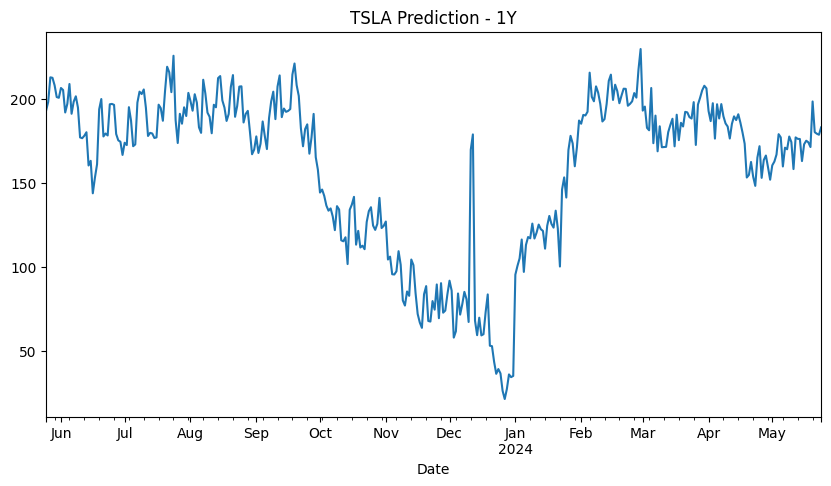

In [262]:
futures['Predictions'].plot(figsize=(10,5),  title='TSLA Prediction - 1Y');

In [258]:
futures['Predictions'].head(10)

Date
2023-05-25    192.933746
2023-05-26    198.117325
2023-05-27    212.679214
2023-05-28    212.405273
2023-05-29    207.968796
2023-05-30    200.957153
2023-05-31    200.511642
2023-06-01    206.342606
2023-06-02    205.159363
2023-06-03    191.805740
Name: Predictions, dtype: float32